<a href="https://colab.research.google.com/github/robinlyl2000/Predict-hand-gestures-using-CNN-Python-version/blob/master/preprocessing_and_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')
from PIL import Image as im

Mounted at /content/drive


In [ ]:
total_file_num = 1 # 檔案總數
signal_len = 1000 # 單一訊號長度

X_data = np.zeros((0,signal_len,8))
Y_data = np.array([])

In [ ]:
from scipy import signal
import math
def emg_filter(EMG):

  # 基準線歸0
  emg = EMG - np.mean(EMG)

  # 使用帶通濾波器
  high = 20/(1000/2)
  low = 450/(1000/2)
  b, a = signal.butter(4, [high,low], btype='bandpass')
  emg_filtered = signal.filtfilt(b, a, emg)

  # 取絕對值
  emg_rectified = abs(emg_filtered)

  # 使用低通濾波器
  low_pass = 3/(1000/2) 
  b2, a2 = signal.butter(4, low_pass, btype='lowpass')
  res = signal.filtfilt(b2, a2, emg_rectified)
  
  return res[:signal_len]

In [ ]:
count = 0

for t in range(1, total_file_num+1):
  df = pd.read_csv('/content/drive/MyDrive/Final/S{:02d}.csv'.format(t)).dropna()
    
  # 找出 class value 轉換處
  df["class"] = df["class"].values.astype(int)
  temp = df["class"].diff()
  split_index = temp[temp != 0].index.values
  last_index = df.index[-1]
  split_index = np.concatenate([split_index, [last_index]])
  
  for i in range(len(split_index) - 1):
    # 取前 1050 筆資料
    df1 = df.loc[split_index[i]: split_index[i+1]-1,:]
    class_value = int(df1["class"].values[0])
    
    if class_value != 0 and class_value != 7: # 排除 Gesture 0 與 7
      Y_data = np.append(Y_data, class_value)
      df2 = df1.drop(['time', 'class', 'label'], axis = 1)
      df3 = pd.DataFrame(columns=["channel{}".format(i+1) for i in range(8)])
      # 將 Raw Data 過濾處理
      for column in df2.keys():
        df3[column] = emg_filter(df2[column])
      df3 = df3 * 1000 # 增強訊號
      EMG = df3.to_numpy().copy()
      EMG.resize(1, signal_len, 8)
      X_data = np.concatenate((X_data, EMG))
      
  print("完成S{:02d}.csv".format(t))


In [ ]:
print(X_data.shape)
print(Y_data.shape)

(24, 1000, 8)
(24,)


(12, 1000, 8)


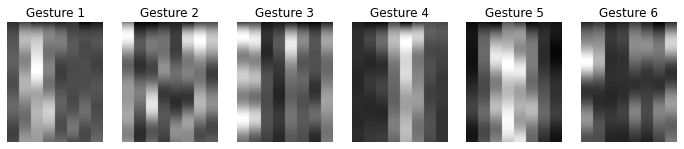

In [ ]:
# 顯示 X_data 模樣
temp_x = np.zeros((12, 1000, 800))
x = X_data[:12]
print(x.shape)
for i in range(12):
  for k in range(8):
    for j in range(1000):
      for l in range(100):
        temp_x[i][j][k * 100 + l] = x[i][j][k]
fig = plt.figure(figsize = (12, 36))
for i in range(0, 6):
  plt.subplot(1, 6, i+1)
  plt.title("Gesture {}".format(int(Y_data[i])))
  plt.axis("off")
  plt.imshow(temp_x[i], cmap = "gray")

In [ ]:
X_data = X_data.reshape(-1, signal_len, 8, 1)
Y_data = Y_data.astype(int)

In [ ]:
# 處理 Training 與 Testing Data
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=11)
Y_train_onehot = np_utils.to_categorical(Y_train, 7)
Y_test_onehot = np_utils.to_categorical(Y_test, 7)
Y_test_onehot = np.array([item[1:] for item in Y_test_onehot])
Y_train_onehot = np.array([item[1:] for item in Y_train_onehot])

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train_onehot.shape)
print(Y_test_onehot.shape)

(691, 1050, 8, 1)
(173, 1050, 8, 1)
(691, 6)
(173, 6)


## 訓練模型

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.optimizers import SGD
from keras import utils

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 66, 8, 32)         512       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 4, 32)          2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 100)               5

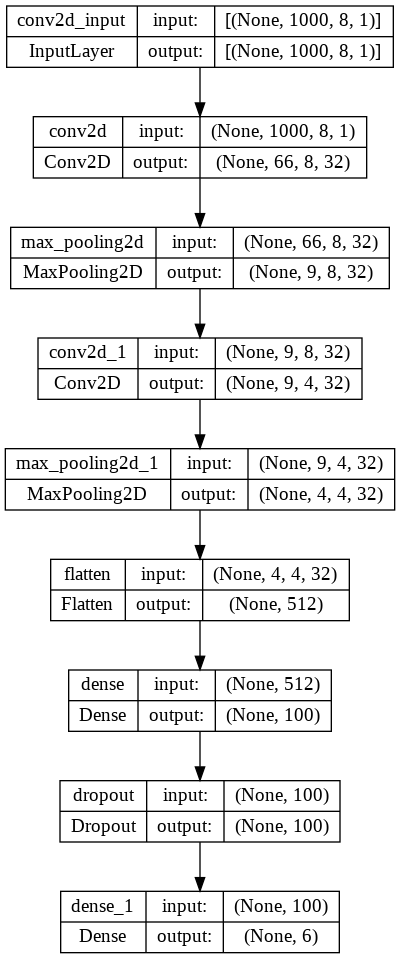

In [ ]:
# 模型建立
model = Sequential()
model.add(Conv2D(32, (15, 1), input_shape=(1000, 8, 1), strides = (15, 1), activation = 'relu')) 
model.add(MaxPooling2D((7, 1))) 
model.add(Conv2D(32, (1, 2), strides= (1, 2), activation = 'relu'))
model.add(MaxPooling2D((2, 1))) 
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(6, activation='softmax'))

# 模型編譯
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())
# 連結圖
utils.plot_model(model, show_shapes=True) 

In [ ]:
# 拿 Testing set 去預測
history = model.fit(x =X_train, y = Y_train_onehot, validation_split = 0.2, epochs = 40, batch_size = 15, verbose = 0)

CNN Accuracy: 87.86127


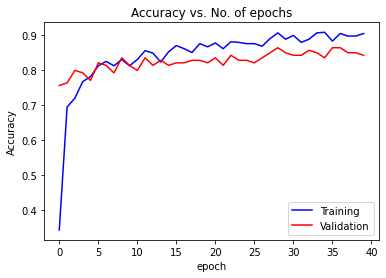

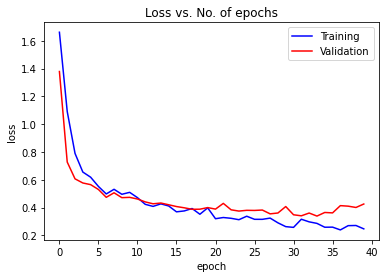

In [ ]:
# 模型評估
def plot_accuracies(history):
    train_accuracies = history.history['accuracy']
    val_accuracies = history.history['val_accuracy']
    plt.plot(train_accuracies, '-b')
    plt.plot(val_accuracies, '-r')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']
    plt.plot(train_losses, '-b')
    plt.plot(val_losses, '-r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    plt.show()

scores = model.evaluate(X_test, Y_test_onehot, verbose = 0)
print("CNN Accuracy: {:.5f}".format(scores[1]*100))
plot_accuracies(history)
plot_losses(history)
plt.show()

[Text(33.0, 0.5, 'y_test'), Text(0.5, 15.0, 'y_pred')]

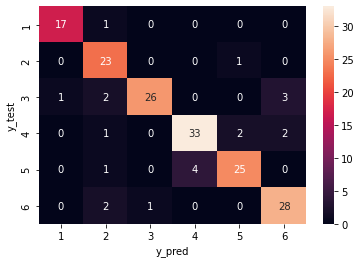

In [ ]:
# 顯示混淆矩陣
import seaborn as sns
df = pd.DataFrame()
y_pred = np.argmax(model.predict(X_test), axis=1)
cross = pd.crosstab(y_pred, Y_test, rownames=['label'])
categories = [str(i) for i in range(1, 7)]
ax = sns.heatmap(cross, annot = True, xticklabels = categories, yticklabels = categories)
ax.set(xlabel = "y_pred", ylabel = "y_test")